**Project Scoping**: Adding USPORF splitting criteria to sklearn. 

Steps taken:  

1) Followed sklearn documentation to fork sklearn repository to my own repository and create my own branch called my-feature.   
2) Forked SPORF repository to my own branch using the same process as above.  
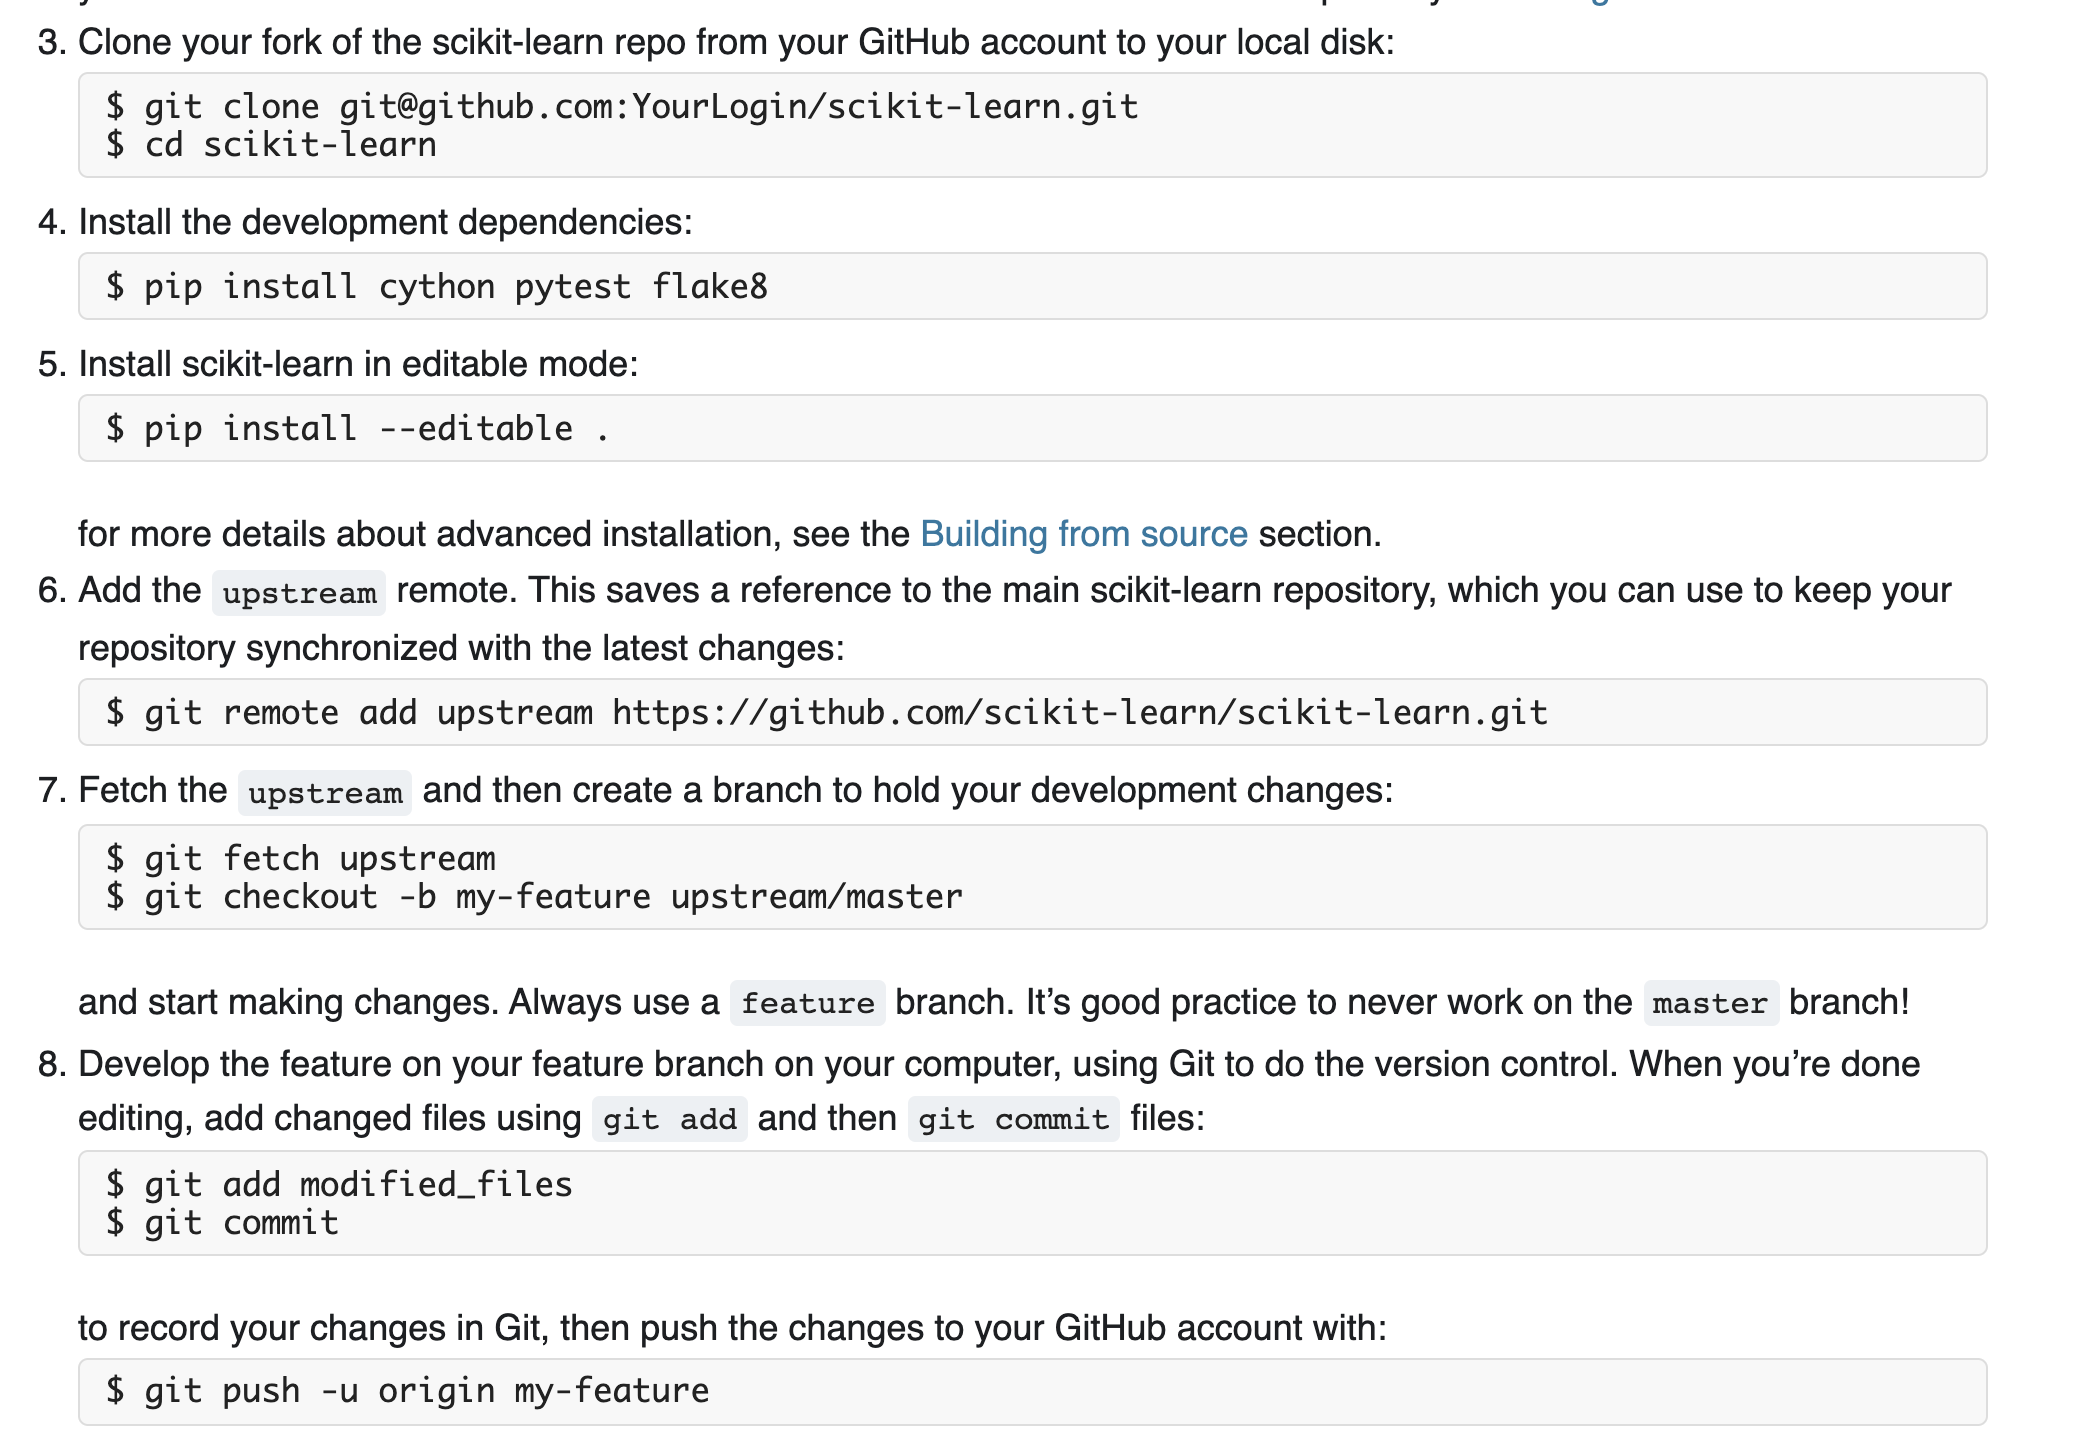
source: https://scikit-learn.org/stable/developers/contributing.html

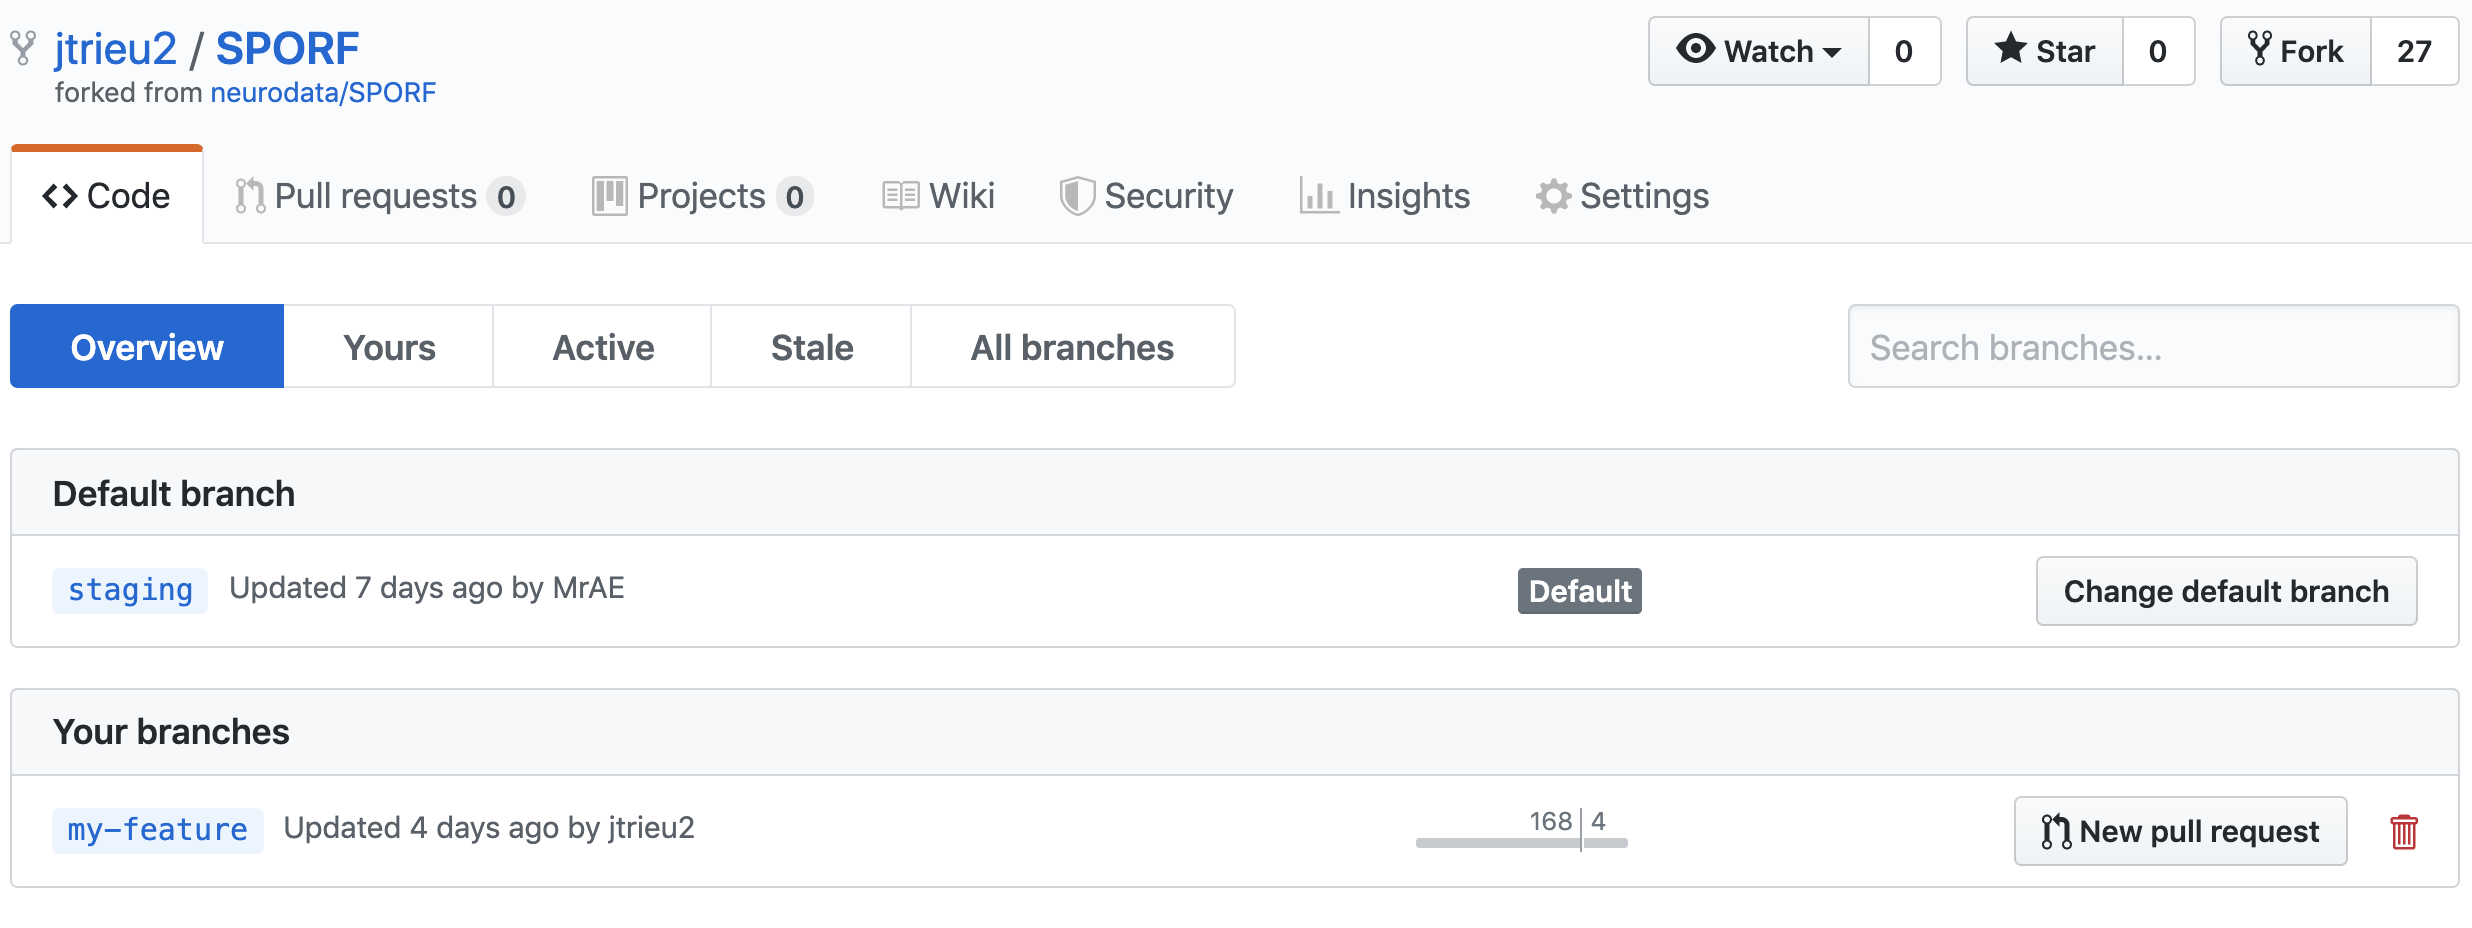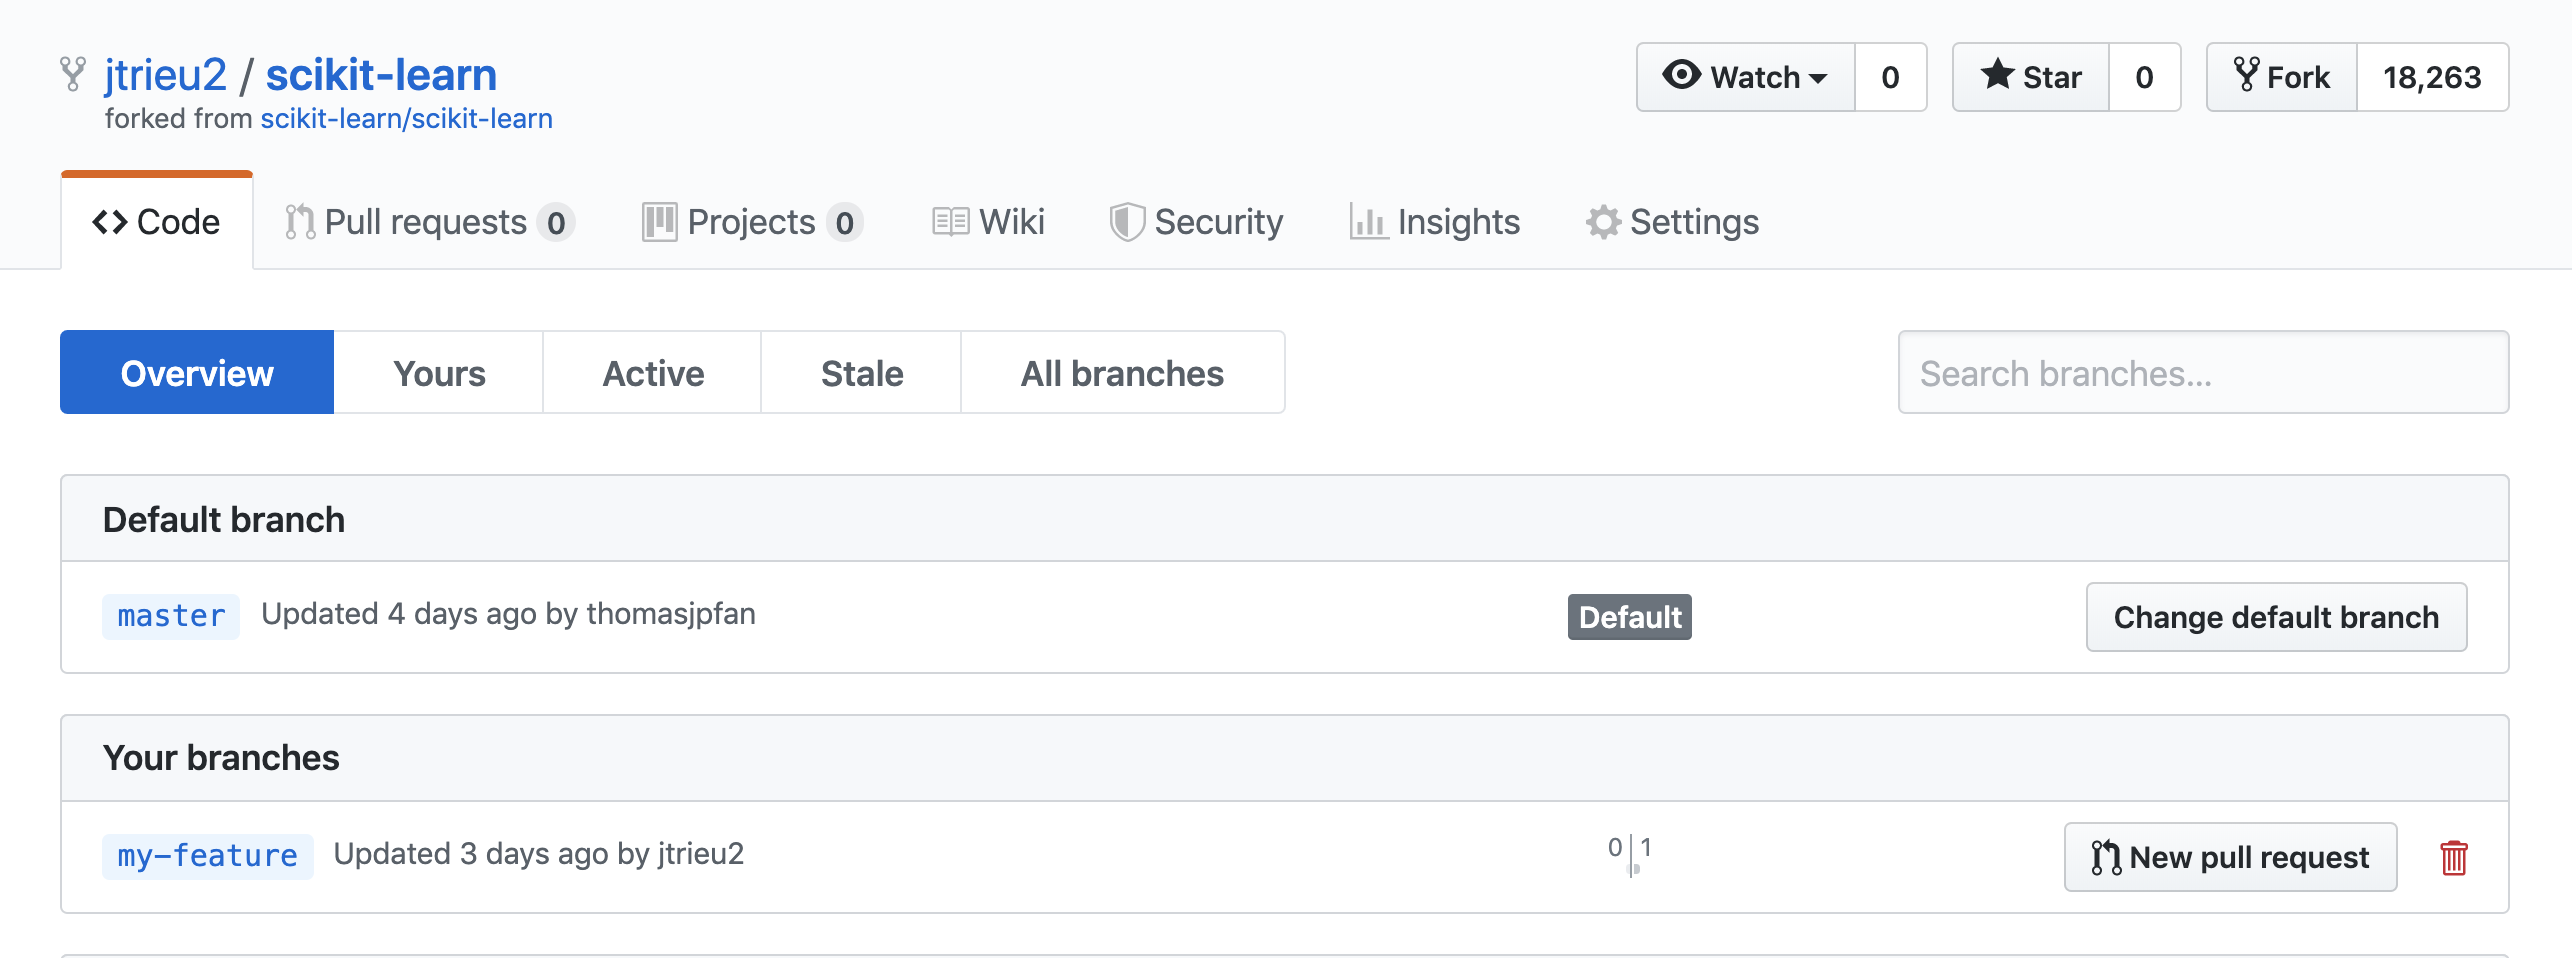

After forking and branching, I then modified an sklearn file by adding in an unsupervised random forest option to the forest.py file in sklearn.!
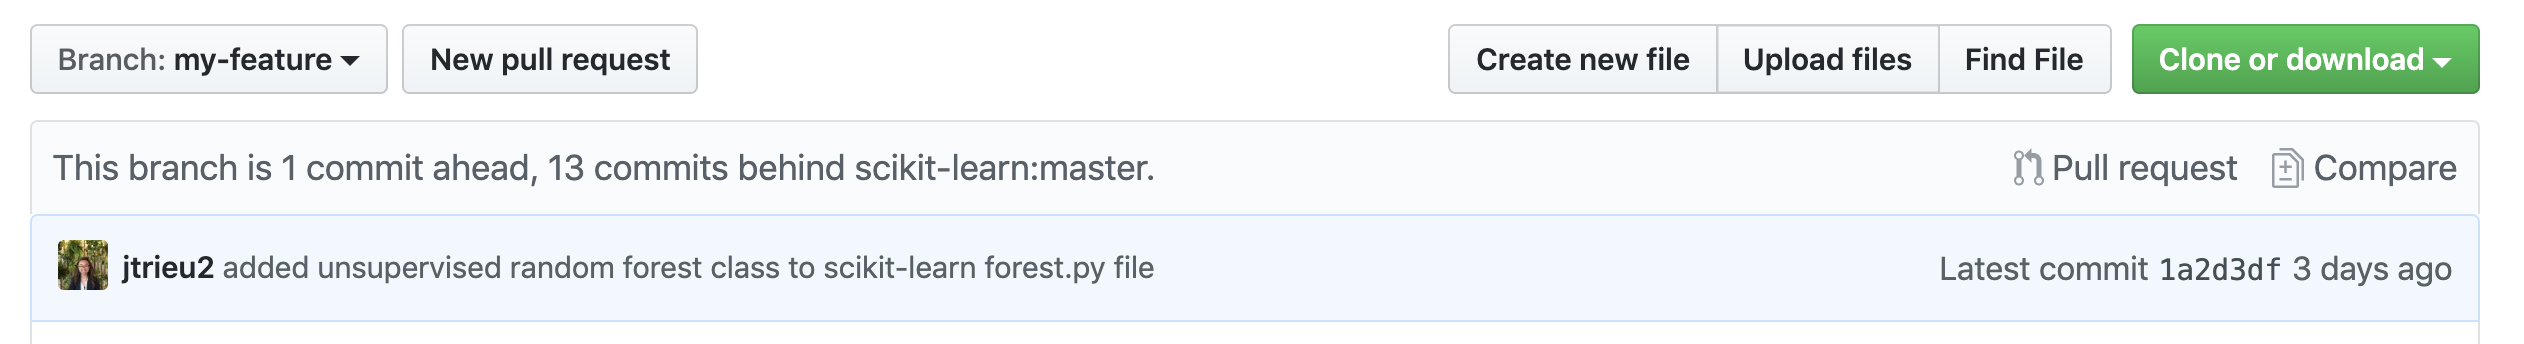


To implement the splitting the splitting criteria, I then did some digging to found where sklearn's splitting criteria code is stored.


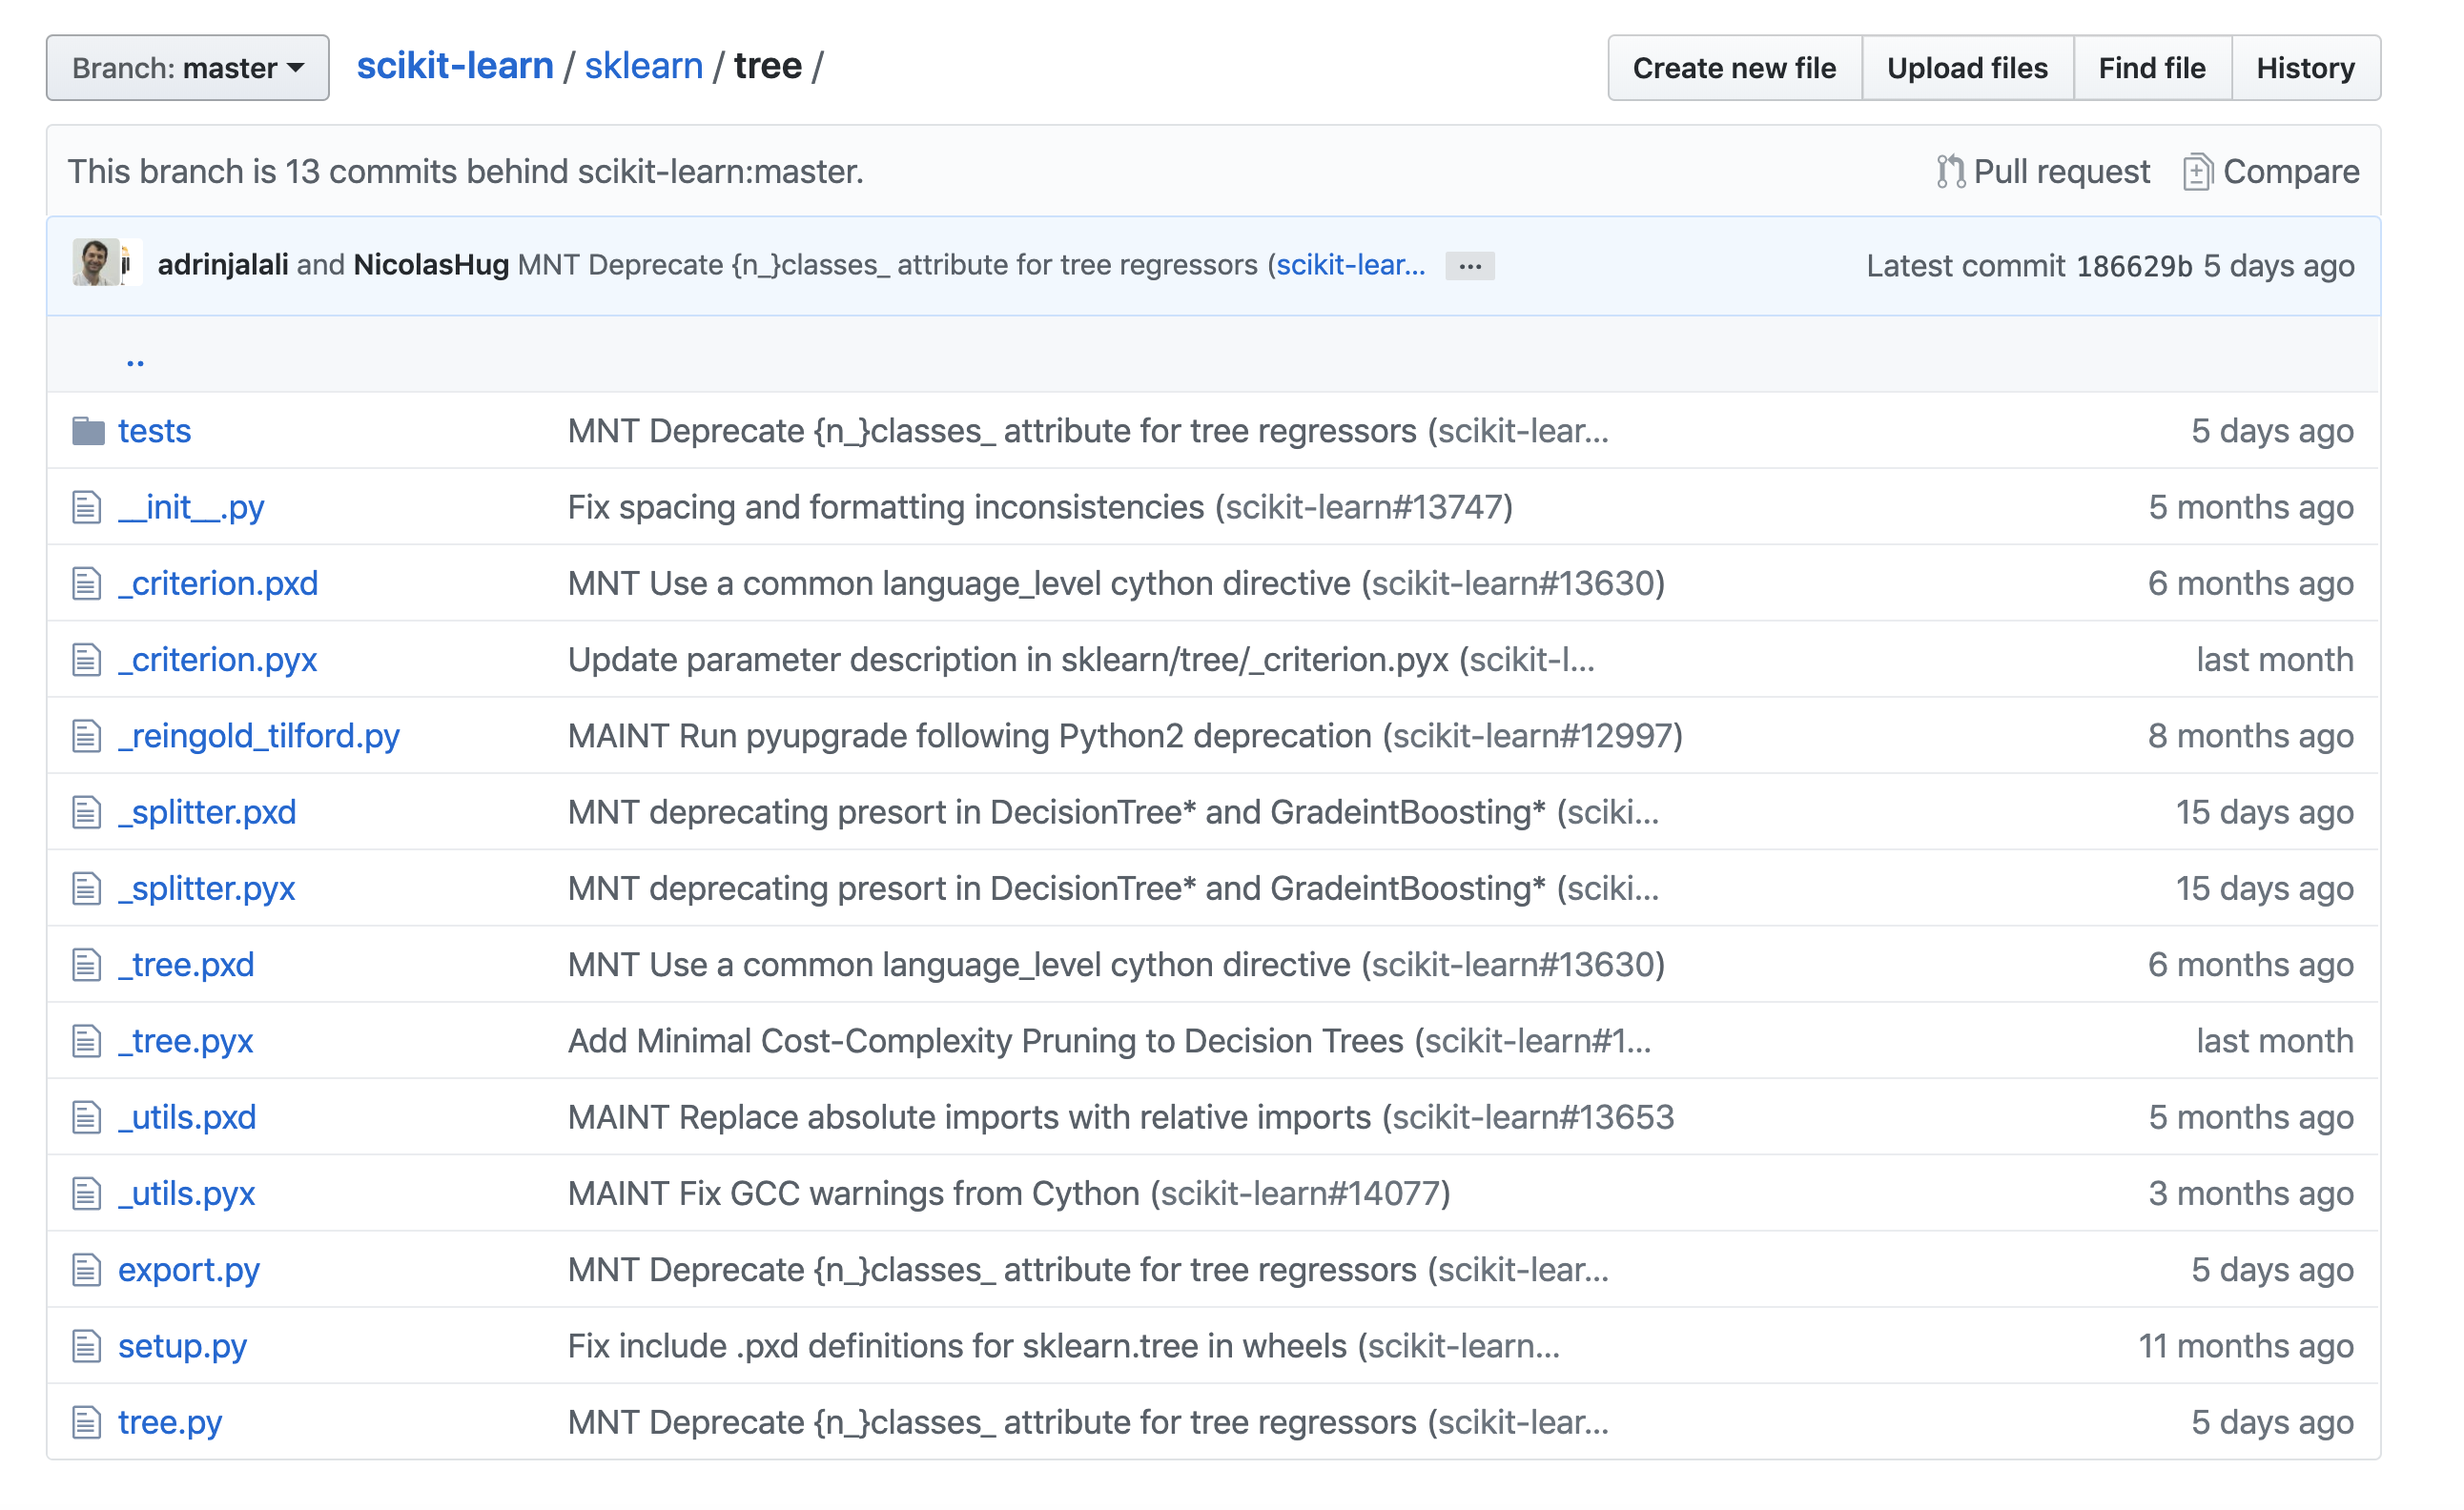


Cython Learning Necessary --> time to see if I can run simple cython code in jupyter notebook before diving headfirst into the Cython files from sklearn.  

Followed steps from this: https://towardsdatascience.com/speed-up-your-python-code-with-cython-8879105f2b6f to produce results below. 

In [2]:
%load_ext Cython

In [3]:
%%cython -a
def fibonacci(n):
    if n < 0:
        print("1st fibonacci number = 0")
    elif n == 1:
        return 0
    elif n == 2:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

In [4]:
%%cython

cdef class Splitter:
  def __cinit__(self, Criterion criterion, SIZE_t max_features,
                  SIZE_t min_samples_leaf, double min_weight_leaf,
                  object random_state):
        self.criterion = criterion
        self.samples = NULL
        self.n_samples = 0
        self.features = NULL
        self.n_features = 0
        self.feature_values = NULL

        self.sample_weight = NULL

        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_leaf = min_weight_leaf
        self.random_state = random_state


Error compiling Cython file:
------------------------------------------------------------
...

cdef class Splitter:
  def __cinit__(self, Criterion criterion, SIZE_t max_features,
                     ^
------------------------------------------------------------

.ipython/cython/_cython_magic_7902a05b8855120dd85f78480fda6611.pyx:3:22: 'Criterion' is not a type identifier

Error compiling Cython file:
------------------------------------------------------------
...

cdef class Splitter:
  def __cinit__(self, Criterion criterion, SIZE_t max_features,
                                          ^
------------------------------------------------------------

.ipython/cython/_cython_magic_7902a05b8855120dd85f78480fda6611.pyx:3:43: 'SIZE_t' is not a type identifier

Error compiling Cython file:
------------------------------------------------------------
...

cdef class Splitter:
  def __cinit__(self, Criterion criterion, SIZE_t max_features,
                  SIZE_t min_samples_leaf, double

TypeError: object of type 'NoneType' has no len()

Code above seems not to be able to work because the Criterion class is imported from somewhere else. Next step --> look into Criterion pxd file and see if I can create the class in the cell above Splitter.

In [5]:
%%cython

cdef class Criterion:
    """Interface for impurity criteria.
    This object stores methods on how to calculate how good a split is using
    different metrics.
    """

    def __dealloc__(self):
        """Destructor."""

        free(self.sum_total)
        free(self.sum_left)
        free(self.sum_right)

    def __getstate__(self):
        return {}

    def __setstate__(self, d):
        pass

    cdef int init(self, const DOUBLE_t[:, ::1] y, DOUBLE_t* sample_weight,
                  double weighted_n_samples, SIZE_t* samples, SIZE_t start,
                  SIZE_t end) nogil except -1:
        """Placeholder for a method which will initialize the criterion.
        Returns -1 in case of failure to allocate memory (and raise MemoryError)
        or 0 otherwise.
        Parameters
        ----------
        y : array-like, dtype=DOUBLE_t
            y is a buffer that can store values for n_outputs target variables
        sample_weight : array-like, dtype=DOUBLE_t
            The weight of each sample
        weighted_n_samples : double
            The total weight of the samples being considered
        samples : array-like, dtype=SIZE_t
            Indices of the samples in X and y, where samples[start:end]
            correspond to the samples in this node
        start : SIZE_t
            The first sample to be used on this node
        end : SIZE_t
            The last sample used on this node
        """

        pass

    cdef int reset(self) nogil except -1:
        """Reset the criterion at pos=start.
        This method must be implemented by the subclass.
        """

        pass

    cdef int reverse_reset(self) nogil except -1:
        """Reset the criterion at pos=end.
        This method must be implemented by the subclass.
        """
        pass

    cdef int update(self, SIZE_t new_pos) nogil except -1:
        """Updated statistics by moving samples[pos:new_pos] to the left child.
        This updates the collected statistics by moving samples[pos:new_pos]
        from the right child to the left child. It must be implemented by
        the subclass.
        Parameters
        ----------
        new_pos : SIZE_t
            New starting index position of the samples in the right child
        """

        pass

    cdef double node_impurity(self) nogil:
        """Placeholder for calculating the impurity of the node.
        Placeholder for a method which will evaluate the impurity of
        the current node, i.e. the impurity of samples[start:end]. This is the
        primary function of the criterion class.
        """

        pass

    cdef void children_impurity(self, double* impurity_left,
                                double* impurity_right) nogil:
        """Placeholder for calculating the impurity of children.
        Placeholder for a method which evaluates the impurity in
        children nodes, i.e. the impurity of samples[start:pos] + the impurity
        of samples[pos:end].
        Parameters
        ----------
        impurity_left : double pointer
            The memory address where the impurity of the left child should be
            stored.
        impurity_right : double pointer
            The memory address where the impurity of the right child should be
            stored
        """

        pass

    cdef void node_value(self, double* dest) nogil:
        """Placeholder for storing the node value.
        Placeholder for a method which will compute the node value
        of samples[start:end] and save the value into dest.
        Parameters
        ----------
        dest : double pointer
            The memory address where the node value should be stored.
        """

        pass

    cdef double proxy_impurity_improvement(self) nogil:
        """Compute a proxy of the impurity reduction
        This method is used to speed up the search for the best split.
        It is a proxy quantity such that the split that maximizes this value
        also maximizes the impurity improvement. It neglects all constant terms
        of the impurity decrease for a given split.
        The absolute impurity improvement is only computed by the
        impurity_improvement method once the best split has been found.
        """
        cdef double impurity_left
        cdef double impurity_right
        self.children_impurity(&impurity_left, &impurity_right)

        return (- self.weighted_n_right * impurity_right
                - self.weighted_n_left * impurity_left)

    cdef double impurity_improvement(self, double impurity) nogil:
        """Compute the improvement in impurity
        This method computes the improvement in impurity when a split occurs.
        The weighted impurity improvement equation is the following:
            N_t / N * (impurity - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)
        where N is the total number of samples, N_t is the number of samples
        at the current node, N_t_L is the number of samples in the left child,
        and N_t_R is the number of samples in the right child,
        Parameters
        ----------
        impurity : double
            The initial impurity of the node before the split
        Return
        ------
        double : improvement in impurity after the split occurs
        """

        cdef double impurity_left
        cdef double impurity_right

        self.children_impurity(&impurity_left, &impurity_right)

        return ((self.weighted_n_node_samples / self.weighted_n_samples) *
                (impurity - (self.weighted_n_right / 
                             self.weighted_n_node_samples * impurity_right)
                          - (self.weighted_n_left / 
                             self.weighted_n_node_samples * impurity_left)))




Error compiling Cython file:
------------------------------------------------------------
...
        return {}

    def __setstate__(self, d):
        pass

    cdef int init(self, const DOUBLE_t[:, ::1] y, DOUBLE_t* sample_weight,
                             ^
------------------------------------------------------------

.ipython/cython/_cython_magic_32619171fcd8a91ad2d9be6a82be49c5.pyx:21:30: 'DOUBLE_t' is not a type identifier

Error compiling Cython file:
------------------------------------------------------------
...
        return {}

    def __setstate__(self, d):
        pass

    cdef int init(self, const DOUBLE_t[:, ::1] y, DOUBLE_t* sample_weight,
                                                 ^
------------------------------------------------------------

.ipython/cython/_cython_magic_32619171fcd8a91ad2d9be6a82be49c5.pyx:21:50: 'DOUBLE_t' is not a type identifier

Error compiling Cython file:
------------------------------------------------------------
...

    def __

TypeError: object of type 'NoneType' has no len()

DOUBLE_t is throwing an error. Now very stuck! :( 

Pivot.